In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import * 
from keras.layers import * 
from keras.preprocessing import image
import PIL
import numpy as np

In [3]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale =1./255)
                                  
test_datagen = ImageDataGenerator(rescale = 1./255)

In [4]:
train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/CovidDataset/Train',
                                                target_size=(200,200),
                                                batch_size= 128,
                                                class_mode='binary',shuffle=False)

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/CovidDataset/Val',
                                           target_size = (200,200),
                                           batch_size = 128,
                                           class_mode ='binary',shuffle=False)

Found 224 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [5]:
test_set.class_indices

{'Covid': 0, 'Normal': 1}

In [6]:
from tensorflow.keras.applications import vgg16
vgg16_model=vgg16.VGG16(include_top=False, input_shape=(200, 200, 3))
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [7]:
# Freeze all the layers
for layer in vgg16_model.layers[:]:
    layer.trainable = False
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [8]:
# Create the the model
model = Sequential()
model.add(vgg16_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 1024)              18875392  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 33,591,105
Trainable params: 18,876,417
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

In [10]:
batch_size=128
results=model.fit(train_set, epochs=10,validation_data=test_set,
                  steps_per_epoch=len(train_set),validation_steps=len(test_set),
                  callbacks=keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)
                  )

Epoch 1/10
2/2 [==============================] - 136s 120s/step - loss: 15.6613 - accuracy: 0.0714 - val_loss: 9.9008 - val_accuracy: 0.5000
Epoch 2/10
2/2 [==============================] - 8s 6s/step - loss: 8.7600 - accuracy: 0.5000 - val_loss: 0.2135 - val_accuracy: 0.9500
Epoch 3/10
2/2 [==============================] - 8s 4s/step - loss: 0.0973 - accuracy: 0.9955 - val_loss: 1.1291 - val_accuracy: 0.5000
Epoch 4/10
2/2 [==============================] - 8s 4s/step - loss: 1.1184 - accuracy: 0.5000 - val_loss: 1.1787 - val_accuracy: 0.5000
Epoch 5/10
2/2 [==============================] - 8s 6s/step - loss: 1.1771 - accuracy: 0.5000 - val_loss: 1.0565 - val_accuracy: 0.5000


In [11]:
model.evaluate(test_set)


1/1 [==============================] - 2s 2s/step - loss: 0.2135 - accuracy: 0.9500


[0.21347996592521667, 0.949999988079071]

In [12]:
model.evaluate(train_set)

2/2 [==============================] - 6s 2s/step - loss: 0.1879 - accuracy: 0.9821


[0.18794918060302734, 0.9821428656578064]

In [18]:
model.save('/content/drive/MyDrive/SavedModels/vgg16_keras_Covid.h5')

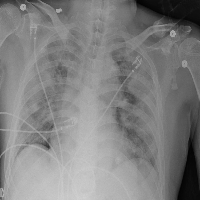

In [19]:
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocess_input, decode_predictions,VGG16
img1 =image.load_img('/content/drive/MyDrive/CovidDataset/Val/Covid/16654_4_1.jpg',target_size =(200,200))
img1


In [20]:
img =image.img_to_array(img1)
img.shape
img = img/255
img =np.expand_dims(img, axis =0)
img.shape

(1, 200, 200, 3)

In [22]:
y_pred_img = model.predict(img)
if y_pred_img>= 0.5:
    prediction = 'normal'
else:
    prediction = 'covid'
print(prediction)

covid


In [23]:
y_pred=model.predict(test_set)
y_pred[0:5]

array([[0.02349592],
       [0.01218832],
       [0.01718516],
       [0.1450176 ],
       [0.00389916]], dtype=float32)

In [24]:
y_pred1=(y_pred>=0.5).astype(int)
y_pred1[0:5]

array([[0],
       [0],
       [0],
       [0],
       [0]])

In [25]:
from sklearn.metrics import accuracy_score,  confusion_matrix
print(confusion_matrix(test_set.labels,y_pred1))

accuracy_score(test_set.labels,y_pred1)*100

[[30  0]
 [ 3 27]]


95.0